### General description of the dataset

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('agaricus-lepiota.data', sep=',', header=None)
# Add column IDs
# I am lazy so I will just read them from a file
colnames = pd.read_csv('colnames.txt', header=None)
colID = ['target']
for i in colnames[0]:
    colID.append(i)

data.columns = colID
target_var = data['target']
data.drop('target', axis = 1, inplace=True)
y = LabelEncoder().fit_transform(target_var) # p == 1, e == 0
print(data.columns)
data.head()

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


## Question to answer with the dataset

1. is there a quick and simple parameter that could be able to discriminate between poisonous and non poisonous data (reasoning with animals)?

2. is there any observable variation for plant parts (cap, gill, stalk, veil, or ring) able to discriminate between poisonous and edible mushrooms

3. Use all the dataset

4. Try to combine multiple data source and make an ensemble learning

### 1. is there a quick and simple parameter that could be able to discriminate between poisonous and non poisonous data

Some animals, especially rodents and small mammals, eat mushrooms and thus they should be able to discriminate between poisonous and edible. Except humans, the majority of mammals have a more developed sense of smells, and a less developed sight, especially regarding number of features or for distinguishing between colors. Thus I will look how good the mushrooms odor could discriminate between edible and posonous

        E    P
odor          
a     1.0  0.0
c     0.0  1.0
f     0.0  1.0
l     1.0  0.0
m     0.0  1.0


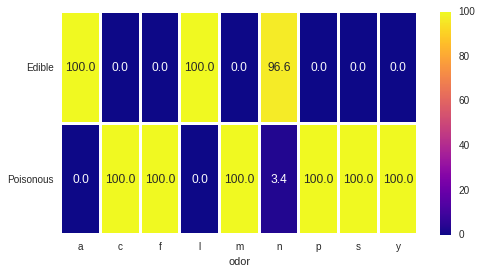

In [4]:
# Animals have good smells and need to recognize if a mushroom is poisonous
# I will look

# create DF with odor data
odor = pd.DataFrame({'p':y, 'odor':data['odor']})
odor_poison = odor.groupby('odor').sum()
odor_poison_size = odor.groupby('odor').size()
odor_data = pd.DataFrame({'P': odor_poison['p']/odor_poison_size, 
                          'E':(odor_poison_size-odor_poison['p'])/odor_poison_size})
print(odor_data.head())
sns.set_style('whitegrid')
plt.figure(figsize=(8,4))
sns.set(style='whitegrid', context='notebook')
sns.heatmap(odor_data.T*100, fmt = '.1f', cmap = 'plasma', cbar = True, annot = True, 
            linewidth = 2, yticklabels=('Edible', 'Poisonous'))
plt.yticks(rotation=0)
plt.show()

             precision    recall  f1-score   support

     edible       0.97      1.00      0.99      4208
  poisonous       1.00      0.97      0.98      3916

avg / total       0.99      0.99      0.99      8124

Accuracy:  0.985228951256


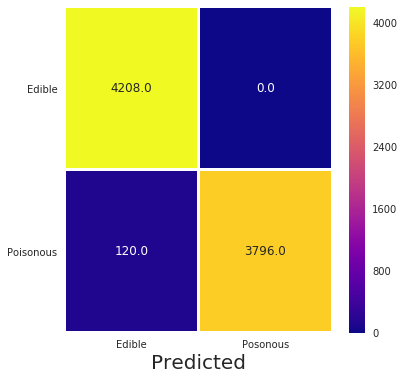

In [88]:
## create a small decision rule for categorical variables
## maybe you can include it in a separate class so you can use
## a custom majority vote classifier

from sklearn.base import BaseEstimator, TransformerMixin

class OdorDecision(BaseEstimator, TransformerMixin):
    def __init__(self, non_poison=['a', 'l', 'n']):
        self.non_poison = non_poison
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        pred = [0 if i in self.non_poison else 1 for i in X]
        return pred
    
#def odor_decision_rule(odor_vars):
#    non_poison = ['a', 'l', 'n']
#    pred = [0 if i in non_poison else 1 for i in odor_vars]
 #   return pred

X = data['odor'].values
od = OdorDecision()
pred = od.predict(X)
print(classification_report(y, pred, target_names = ['edible', 'poisonous']))
print('Accuracy: ', accuracy_score(y, pred))
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y, pred),
           cmap = 'plasma', annot = True,
            fmt = '.1f', cbar = True,linewidth = 2, 
            yticklabels=('Edible', 'Poisonous'),
            xticklabels=('Edible', 'Posonous')
           )
plt.yticks(rotation=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel
plt.show()


## 2. is there any observable variation for plant parts (cap, gill, stalk, veil, or ring) able to discriminate between poisonous and edible mushrooms (you can use LDA on single organs?

### 2.1 caps

In [102]:
caps = data[['cap-shape', 'cap-surface', 'cap-color']]
X_dum = pd.get_dummies(caps).values

X_train, X_test, y_train, y_test= train_test_split(X_dum, y,
                                                  test_size=0.2, random_state=101)

rfc_caps = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_caps.fit(X_train, y_train)

# test in sample precision with CV

y_train_pred = cross_val_predict(rfc_caps, X_train, y_train, cv = 5)

print(classification_report(y_train, y_train_pred, target_names = ['edible', 'poisonous']))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

     edible       0.70      0.75      0.73      3357
  poisonous       0.71      0.66      0.68      3142

avg / total       0.71      0.71      0.71      6499

Accuracy:  0.706108632097


Not really good though, even though the model is not overfitting!!

### 2.2 Gills

In [103]:
gills = data[['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']]

X_gills = pd.get_dummies(gills).values

X_train, X_test, y_train, y_test = train_test_split(X_gills, y,
                                                   test_size = 0.2, random_state = 101)

rfc_gills = RandomForestClassifier(n_estimators=100, random_state=42)

rfc_gills.fit(X_train, y_train)

# In sample precision with CV
y_train_pred = cross_val_predict(rfc_gills, X_train, y_train, cv = 5)
print(classification_report(y_train, y_train_pred))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.94      0.82      0.88      3357
          1       0.83      0.95      0.89      3142

avg / total       0.89      0.88      0.88      6499

Accuracy:  0.883366671796


Gills are definitely a best predictor overall for this problem

### 2.3 Stalk

In [104]:
stalks = data[['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']]

X_stalks = pd.get_dummies(stalks).values

X_train, X_test, y_train, y_test = train_test_split(X_stalks, y,
                                                   test_size=0.2, random_state=101)

rfc_stalks = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_stalks.fit(X_train, y_train)

# in sample
y_train_pred = cross_val_predict(rfc_stalks, X_train, y_train, cv = 5)
print(classification_report(y_train, y_train_pred))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.98      0.97      0.98      3357
          1       0.97      0.98      0.98      3142

avg / total       0.98      0.98      0.98      6499

Accuracy:  0.976304046776


THe stalks are the one most predictive so far

### 2.4 Veil

In [105]:
veil = data[['veil-type', 'veil-color']]

X_veil = pd.get_dummies(veil).values

X_train, X_test, y_train, y_test = train_test_split(X_veil, y,
                                                   test_size=0.2, random_state=101)

rfc_veil = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_veil.fit(X_train, y_train)

# in sample
y_train_pred = cross_val_predict(rfc_veil, X_train, y_train, cv = 5)
print(classification_report(y_train, y_train_pred))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.52      1.00      0.68      3357
          1       1.00      0.00      0.00      3142

avg / total       0.75      0.52      0.35      6499

Accuracy:  0.517464225265


 Veil is really accurate for predict poison mushrooms!
 
 ### 2.5 Rings

In [106]:
rings = data[['ring-number','ring-type']]

X_ring = pd.get_dummies(rings)

X_train, X_test, y_train, y_test = train_test_split(X_ring, y,
                                                   test_size=0.2, random_state=101)

rfc_ring = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_ring.fit(X_train, y_train)

y_train_pred = cross_val_predict(rfc_ring, X_train, y_train, cv = 5)
print(classification_report(y_train, y_train_pred))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.80      0.80      0.80      3357
          1       0.79      0.79      0.79      3142

avg / total       0.80      0.80      0.80      6499

Accuracy:  0.795507001077


## 3 Use all dataset

In [108]:
X = pd.get_dummies(data).values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2, random_state=101)

rfc_all = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_all.fit(X_train, y_train)

y_train_pred = cross_val_predict(rfc_all, X_train, y_train, cv = 10)
print(classification_report(y_train, y_train_pred))
print('Accuracy: ', accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3357
          1       1.00      1.00      1.00      3142

avg / total       1.00      1.00      1.00      6499

Accuracy:  1.0


In [109]:
# out of sample precision
y_pred = rfc_all.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       851
          1       1.00      1.00      1.00       774

avg / total       1.00      1.00      1.00      1625

1.0


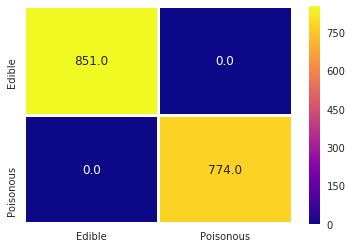

In [110]:
sns.heatmap(confusion_matrix(y_test, y_pred),
           cmap = 'plasma', annot = True,
            fmt = '.1f', cbar = True,linewidth = 2, 
            yticklabels=('Edible', 'Poisonous'),
            xticklabels=('Edible', 'Poisonous'))

In [125]:
# plot feature importances based on RF on all dataset